# Notebook 3

### In this notebook
1. Estimate transition kernel $K_{ij}$
2. Calculate transition lifetimes between disks $\tau_i$
3. Performe steady state flux calculation $q_i$
4. Calculate free energy profile $F_i$

### Import libraries

In [82]:
# python libs
import sys
import pytraj as pt
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd

# BKit modules
from BKit.TransitionKernel import TransitionKernel
from BKit.KinSolvers import KineticsQK

### Load microstate labels of all short MDs

In [83]:
dat_path = '../output/'
file_name = 'CellIndx.npy'
print("reading inputs from " + dat_path)
labels = np.load(dat_path + file_name)

reading inputs from ../output/


###  Collect transitions between disks

In [84]:
TransK = TransitionKernel(traj_size=1000, OutCellID=1000, check_escape=True)
TRANS = TransK.AllTrans(labels, frac=1.)
nM = TRANS[:,2].max() # number of milestones

number of trajs 8620
Total transitions =  234473


In [85]:
df = pd.DataFrame(TRANS)
df.columns = ['frame_id','disk_i','disk_j','time_i','time_j']

In [86]:
df.tail()

,frame_id,disk_i,disk_j,time_i,time_j
234468,8606,48,47,268,269
234469,8606,51,50,291,297
234470,8606,54,53,322,323
234471,8611,54,53,286,287
234472,8611,53,52,287,288


### CalculateTransition Kernel  and average lifetime of each milestone

In [87]:
KMAT, time = TransK.Kmat_time(TRANS, nM)
ave_time = np.array(time)[:,1]  
t_std = np.array(time)[:,2] 
F_std = 0.6*t_std/ave_time

### $$\bf{K}_{ij} \simeq \frac{n_{ij}}{n_i} $$

* $n_i$ - number of conformations started at disk $i$
* $n_{ij}$ - part of $n_i$ that landed in a disk $j$
* Transition lifetime (ave_time) 

### Visualize transition kernel (it is neirest neighbour)

Text(0, 0.5, 'Unbinding Index')

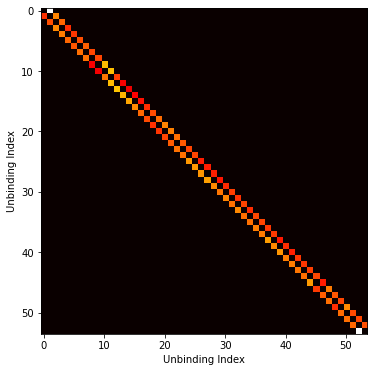

In [88]:
fig = plt.figure(figsize=[8,6])
ax = plt.imshow(KMAT, cmap='hot')
plt.xlabel('Unbinding Index')
plt.ylabel('Unbinding Index')
#plt.text(60,30,s=r'$\alpha$')

#### $$\bf{K} = 
      \left(\begin{array}{cccccccccc}
        0.0 & 1.0 & 0.0 & \ldots\\
        0.4 & 0.0 & 0.6 & 0.0 & \ldots  \\
        0.0 & 0.5 &  0.0 & 0.5 & 0.0 & \ldots\\
        0.0 & 0.0 & \ddots &  \ddots & \ddots & 0.5 & 0.0  \\
        & \ldots &  0.0 & 0.0 &  0.6 & 0.0 & 0.4 \\
        & & \ldots & 0.0 & 0.0 &  1.0 & 0.0 \\
      \end{array}\right)$$

### Solve for stationary flux, $q$

In [89]:
# Provide appropriative boundary conditions
bc_beg = ''
bc_end = 'reflective'

KineticsQK class has functions for both Power Iteration and Eigensolver methods.


In [90]:
QK = KineticsQK(KMAT, ave_time, nM, bc = [bc_beg, bc_end])

### Power Iteration method

### $$ q_{i}^{t+1} = q_{i-1}^{t} \frac{K_{i-1,i}}{\sum_{i} q_{i}^{t}} + q_{i+1}^{t} \frac{K_{i+1,i}}{\sum_{i} q_{i}^{t}}$$

* This expression is iteratively updated until change in $q_i$ becomes negligable
* Free energy per microstate: $F_i = -k_{B}T \log{(q_i \tau_i)}$

In [91]:
PMF_power, q_power = QK.PowerIter(n_iters=30000)
PMF_power = PMF_power - PMF_power.min()

### Eigensolver method

### $$ K \bf{q} = \lambda \bf{q}$$

* Eigenvector corresponding to highest eigenvalue gives steady state flux $q$
* $\lambda$ - eigenvalues
* $q$ - eigenvectors
* Free energy per microstate: $F_i = -k_{B}T \log{(q_i \tau_i)}$

In [92]:
PMF_eigen, q_eigen = QK.EigenSolver()
PMF_eigen = PMF_eigen - PMF_eigen.min()

###  Compare q obtained from both methods

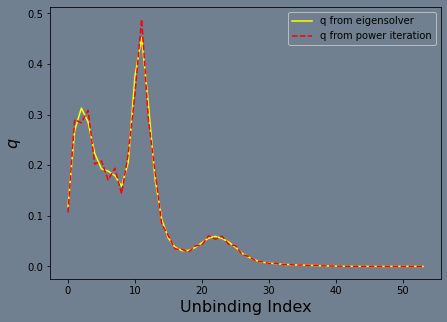

In [93]:
cl='slategrey'
fig=plt.figure(figsize=[7,5],facecolor=cl)
plt.rcParams['axes.facecolor'] = cl
plt.plot( range(len(q_eigen)), abs(q_eigen), color='yellow', label='q from eigensolver')
plt.plot( range(len(q_power)), q_power, '--',color='r', label='q from power iteration')
plt.legend()    
plt.xlabel('Unbinding Index', fontsize=16)
plt.ylabel(r'$q$', fontsize=16)
plt.show()

###  Visualize the potential of mean force (PMF) profile

In [94]:
b=0; f=nM-1

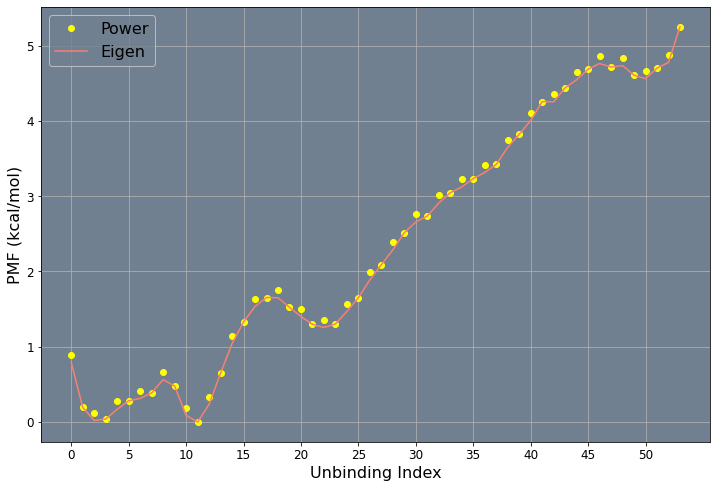

In [95]:
plt.figure(figsize=(12,8))
plt.plot(range(b,f+1), PMF_power, color='yellow', ls='', marker='o' )
plt.plot(range(b,f+1), PMF_eigen, color='salmon')
plt.xlabel('Unbinding Index',fontsize=16)
plt.ylabel('PMF (kcal/mol)', fontsize=16)
plt.xticks(np.arange(b,(f+1), step=5))
plt.tick_params(labelsize=12)
plt.grid()
plt.legend(['Power','Eigen'], fontsize=16)

### Plot with error bars

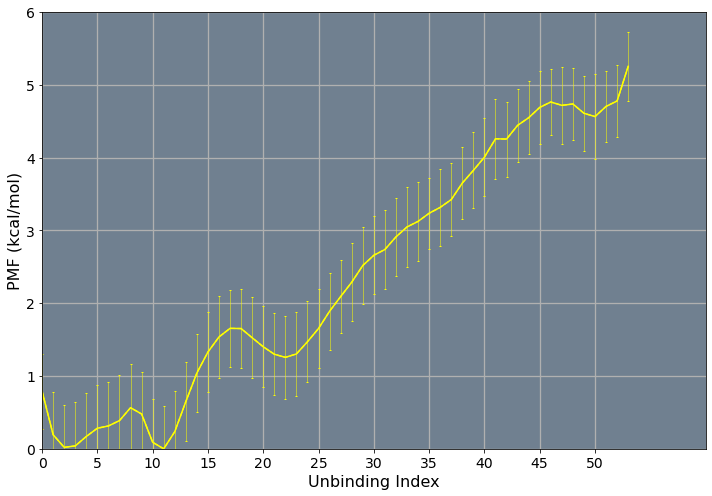

In [101]:
cl='yellow'; t_cl = 'brown'
pl_name = 'Cyc-Asp'
fs = 16; lw=1.3
PMF = PMF_eigen
fig = plt.figure(figsize = [10, 7])

plt.plot(range(b,f+1), PMF, ls='--', lw=lw, color=cl)#, marker='o' )
plt.errorbar(range(b, f+1), PMF, F_std,
             color=cl, ecolor=cl,
             elinewidth=0.5, capsize=1)
plt.xlabel('Unbinding Index',fontsize=fs)
plt.ylabel('PMF (kcal/mol)', fontsize=fs)
plt.xticks(np.arange(b,(f+1), step=5))
plt.tick_params(labelsize=fs-2)
plt.xlim([0,60]); plt.ylim([0,6])
plt.grid(lw=lw)
fig.tight_layout()
plt.show()

### Calculate unbinding free energy, $\Delta G$

In [102]:
b_, f_ = np.argmin(PMF_eigen), np.argmax(PMF_eigen)
print("Free energy between milestones %s and %s:"%(b_, f_))
DeltaG = -(PMF_eigen[f_] - PMF_eigen[b_])
print("\u0394G =\t", DeltaG, "kcal/mol")

Free energy between milestones 11 and 53:
ΔG =	 -5.252593948760823 kcal/mol


In [103]:
b_, f_ = np.argmin(PMF_power), np.argmax(PMF_power)
print("Free energy between milestones %s and %s:"%(b_, f_))
DeltaG = -(PMF_power[f_] - PMF_power[b_])
print("\u0394G =\t", DeltaG, "kcal/mol")

Free energy between milestones 11 and 53:
ΔG =	 -5.252593948761199 kcal/mol


###  Calculate MFPT

### $$ \langle \tau \rangle = \sum_{i=1}^{f} q_i \tau_i / q_f$$

* $q_f$ - is a flux at finale absorbing milestone
* This allows calculation of MFPT for any intermidiate state as well

In [104]:
time = np.array(time)
b = b_; f = f_
print("MFPT from milestone %s to %s:"%(b, f))
mfpt = abs( (q_power[b:f+1]*time[:,1][b:f+1]).sum() / q_power[-1]) / 10**9
print("MFPT =\t %E ms" % mfpt)


MFPT from milestone 11 to 53:
MFPT =	 4.654604E-05 ms


In [105]:
print("MFPT from milestone %s to %s:"%(b, f))
mfpt = abs( (q_eigen[b:f+1]*time[:,1][b:f+1]).sum() / q_eigen[-1]) / 10**9
print("MFPT =\t %E ms" % mfpt)

MFPT from milestone 11 to 53:
MFPT =	 4.986663E-05 ms
